In [ ]:
# TO-DO:
# Improving geolytix and openlocal merges (tweeking the similarity score)
# Getting number of employees for the company and following similar logic

# After I process OpenStreetMaps:
# - Use your existing dataset of store locations.
#     - Calculate the density of similar retailers (e.g., supermarkets) within a 1 km radius using geospatial libraries like geopandas or scipy.
# - I want to calculate how the size of each location i.e. x metres squared 
# - Business rates for each location - https://www.data.gov.uk/dataset/f027145b-b55f-4602-b889-b28a8ca04462/business-rates
# Target variable could be size*business rates


# DONE:
# From Openstreetmap:
# - What it provides: Distance to city centers, shopping hubs, or transport nodes (e.g., train stations).
# - Population -   "gis_osm_places_free_1"
# - Distance from water - gis_osm_waterways_free_1
# - Distance from transport - gis_osm_transport_a_free_1
# Right now I'm working on merging Geolytix & OpenLocal datasets for the following reasons:
    # To get company name accurate -> to get company house data for business_rates/tax/turnover/number of employees etc
    # if we have company turnover/business rates we can divide the store rates paid by the company BAAAAMM 

# Once the LLM works and I can get the turnover values 
    #  Get size of the buildings and use that as a multiplier to estimate turnover.
    # Company turnover * (manchester_sites / uk_sites) = turnover_in_manchester
    # site_size / sum_site_sizes_in_manchester = ratio
    # ratio * turnover_in_manchester = turnover for each site

# GeoMind - Estimating Turnover for businesses in Manchester - GeoTam

## Import Functions

In [1]:
import matplotlib.pyplot as plt
import utils, utils_data_prep
import seaborn as sns
import pandas as pd
import numpy as np

from importlib import reload 
reload(utils)

pd.set_option('display.max_columns', None)

## Data Prep

In [2]:
df, min_lon, max_lon, min_lat, max_lat = utils_data_prep.openlocal_dataset()
df = utils_data_prep.using_ons_datasets(df, postcode="voapropertypostcode")
evaluation_df = pd.DataFrame(columns=["RMSE", "STD", "MAPE", "R2_SCORE", "PCT_NEGATIVE_PREDICTIONS"])

c:\Users\wail.baalawi\AppData\Local\anaconda3\envs\geomind_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\wail.baalawi\OneDrive - Precisely Software Incorporated\Documents\Personal Projects\geomind\utils_data_prep.py:101: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ons_lookup = pd.read_csv("data/raw/ons/PCD_OA_LSOA_MSOA_LAD_MAY22_UK_LU.csv", encoding="latin-1")


In [3]:
def get_multiplier(sector):
    return utils. sector_multipliers.get(sector, utils.sector_multipliers['Other'])
def calculate_turnover(row):
    rv = row['voarateablevalue']
    if rv <= 0:
        return None
    multiplier_range = get_multiplier(row['voascatname'])
    multiplier = sum(multiplier_range) / 2
    return rv * multiplier

df['turnover_estimate'] = df.apply(calculate_turnover, axis=1)


In [4]:
drop_cols = [
    'ogc_fid', "geometry", "longitude", "latitude", "latitude", 
    "voapropertyaddress", "voapropertytown", "voapropertycounty", 
    "voapropertypostcode", "voapostcodecentroid", 
    "voabillingauthoritycode", "voascatcode", "voascatname", 
    "laratesreliefs", "lsoa", "ttwa_code", "town_code", "pc_code", "ward_code", 
    "ccg_code",
    "voarateablevalue"
    ]
target = "turnover_estimate"


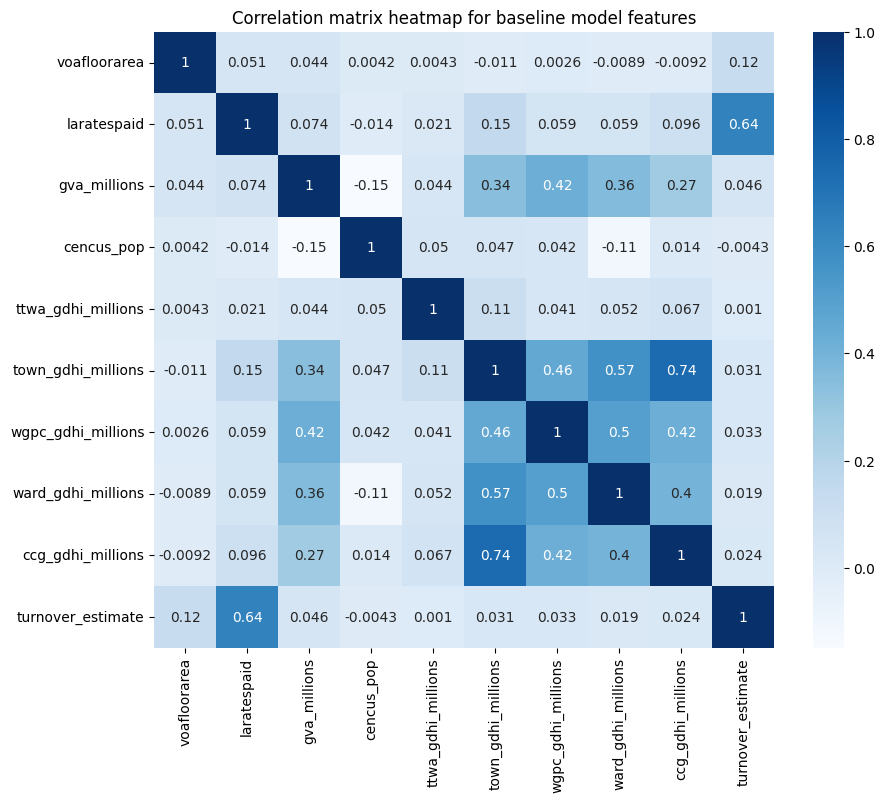

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(drop_cols, axis=1).corr(), annot=True, cmap="Blues")
plt.title("Correlation matrix heatmap for baseline model features")
plt.show()

## Model 1 - Baseline Model 

In [61]:
df[df["voapropertyaddress"].str.contains("LEECH STREET")]
df[df["voascatname"] == "Large Food Stores (750 - 2500m^2)"]
loc_df[loc_df["ogc_fid"] == 1682848]

,ogc_fid,geometry,longitude,latitude,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,turnover_estimate,distance_to_water,nearest_waterway_index,distance_to_transport,nearest_transport_index,normalized_address
101618,1682848,POINT (-249260.815 7066150.979),-2.239148,53.447205,"ALDI 143 LLOYD STREET SOUTH, MANCHESTER, M14 7LA",MANCHESTER,,M14 7LA,0101000000003b376dc6e901c0c8cd70033eb94a40,E08000003,152,Large Food Stores (750 - 2500m^2),1295.0,194000.0,194000.0,,E01005178,12.256126,1975.0,E30000239,E35000486,E14000807,E05011364,E38000217,54907.789249,10101.226153,2748.561603,166.73774,9910.778802,970000.0,963.499542,2464,58.42928,6174,aldi 143 lloyd street south manchester m14 7la


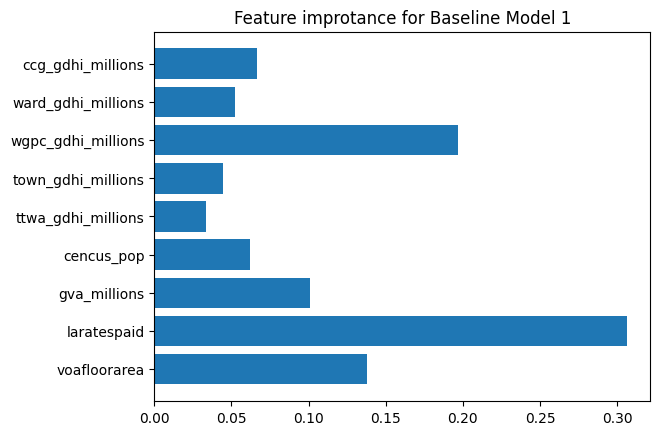

In [6]:
evaluation_df = utils.xgb_model(
    df=df,
    drop_cols=drop_cols,
    target = "turnover_estimate",
    model_type="Baseline Model 1",
    evaluation_df=evaluation_df
)

## Model 2 - Adding geospatial features (calculating distance)

In [7]:
loc_df = utils.using_openstreetmap_data(df)


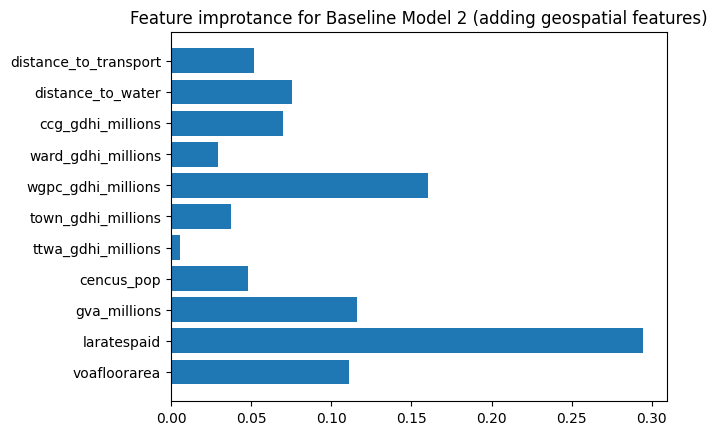

In [8]:
drop_cols = [
    'ogc_fid', "geometry", "longitude", "latitude", "latitude", 
    "voapropertyaddress", "voapropertytown", "voapropertycounty", 
    "voapropertypostcode", "voapostcodecentroid", 
    "voabillingauthoritycode", "voascatcode", "voascatname", 
    "laratesreliefs", "lsoa", "ttwa_code", "town_code", "pc_code", "ward_code", 
    "ccg_code",
    "voarateablevalue",
    "nearest_transport_index", "nearest_waterway_index"
    ]
evaluation_df = utils.xgb_model(
    df=loc_df,
    drop_cols=drop_cols,
    target = "turnover_estimate",
    model_type="Baseline Model 2 (adding geospatial features)",
    evaluation_df=evaluation_df
)

## Model 3 - Estimating turnover based on company turnover and size

### Merging Geolytix and OpenLocal datasets

In [9]:
geolytix_df = pd.read_csv("data/raw/geolytix/geolytix_retailpoints_v33_202408.csv").rename(columns={"long_wgs":"longitude", "lat_wgs":"latitude"})
geolytix_df = geolytix_df[
    (geolytix_df["longitude"] >= min_lon) & (geolytix_df["longitude"] <= max_lon) & (geolytix_df["latitude"] >= min_lat) & (geolytix_df["latitude"] <= max_lat)
]

In [10]:
matches_df = utils.combining_geolytix_openlocal(
    geolytix_df=geolytix_df, 
    openlocal_df=loc_df,
    )


In [32]:
merged_df = (
    geolytix_df
    .merge(matches_df[matches_df.similarity >= 80][["geolytix_id", "openlocal_id"]], left_on="id", right_on="geolytix_id", how="left")
    .drop(["geolytix_id", "bng_e", "bng_n", "pqi"], axis=1)
    .merge(loc_df[[
            "ogc_fid", 'geometry', 'voascatcode',
            'voascatname', 'voafloorarea', 'voarateablevalue', 'laratespaid',
            'gva_millions', 'cencus_pop','ttwa_gdhi_millions',
            'town_gdhi_millions', 'wgpc_gdhi_millions', 'ward_gdhi_millions',
            'ccg_gdhi_millions', 'distance_to_water',  'distance_to_transport',
        ]], left_on="openlocal_id", right_on="ogc_fid", how="left")
    )
merged_df = merged_df[~merged_df.openlocal_id.isna()]

In [33]:
merged_df.retailer.value_counts()

retailer
Tesco                        57
Morrisons                    42
Asda                         39
Aldi                         34
Spar                         31
The Co-operative Group       27
Sainsburys                   24
Lidl                         21
Iceland                      19
Marks and Spencer            10
Farmfoods                     9
Heron                         7
Waitrose                      2
Makro                         1
Cook                          1
Budgens                       1
The Southern Co-operative     1
Costco                        1
Name: count, dtype: int64

### Extracting statistics with an LLM

In [13]:
retail_companies = merged_df.retailer.unique().tolist()
company_stats = {}
for company in retail_companies:
    llm_output = utils.llm_for_statistical_figures(company)
    company_stats.update(llm_output.__root__)
    

In [63]:
estimated_df[estimated_df.index == 1682848]

,id,retailer,fascia,store_name,add_one,add_two,town,suburb,postcode,longitude,latitude,open_date,size_band,county,combined_address,openlocal_id,geometry,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,gva_millions,cencus_pop,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,distance_to_water,distance_to_transport,sum_floor_area,sum_rateable_value,turnover_in_manchester,estimated_turnover
ogc_fid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1682848.0,1010000280,Aldi,Aldi,Aldi Moss Side Manchester,143 Lloyd Street South,-9999,Manchester,Moss Side,M14 7LA,-2.23898,53.447557,-9999.0,"3,013 < 15,069 ft2 (280 < 1,400 m2)",Greater Manchester,143 lloyd street south m14 7la,1682848.0,POINT (-249260.815 7066150.979),152,Large Food Stores (750 - 2500m^2),1295.0,194000.0,194000.0,12.256126,1975.0,54907.789249,10101.226153,2748.561603,166.73774,9910.778802,963.499542,58.42928,38286.98,7819000.0,2.626263e+08,8.882942e+06


In [50]:
grouped_df = merged_df.groupby("retailer").agg({"voafloorarea":"sum", "voarateablevalue":"sum"}).reset_index().rename(columns={"voafloorarea":"sum_floor_area", "voarateablevalue":"sum_rateable_value"})
grouped_df["turnover_in_manchester"] = grouped_df["retailer"].apply(lambda x: company_stats[x].company_turnover_uk * (company_stats[x].number_locations_manchester / company_stats[x].number_locations_uk) if company_stats[x].company_turnover_uk > 0 else np.nan)
estimated_df = merged_df.merge(grouped_df, on="retailer", how="left")
estimated_df["estimated_turnover"] = estimated_df["turnover_in_manchester"] * (estimated_df["voafloorarea"] / estimated_df["sum_floor_area"])

drop_cols = [
    'id', 'retailer', "fascia", 'store_name', 'add_one', 'add_two', 'town', 
    'suburb', 'postcode', 'longitude', 'latitude', 'open_date', 'size_band',
    'county', 'combined_address', 'openlocal_id', 'geometry',
     'voascatname', "sum_floor_area", "sum_rateable_value",
     "voarateablevalue", 
    ]
# estimated_df.drop(drop_cols, axis=1, inplace=True)
estimated_df["voascatcode"] = estimated_df["voascatcode"].astype(int)
estimated_df.set_index("ogc_fid", inplace=True)
estimated_df.fillna(-9999, inplace=True)


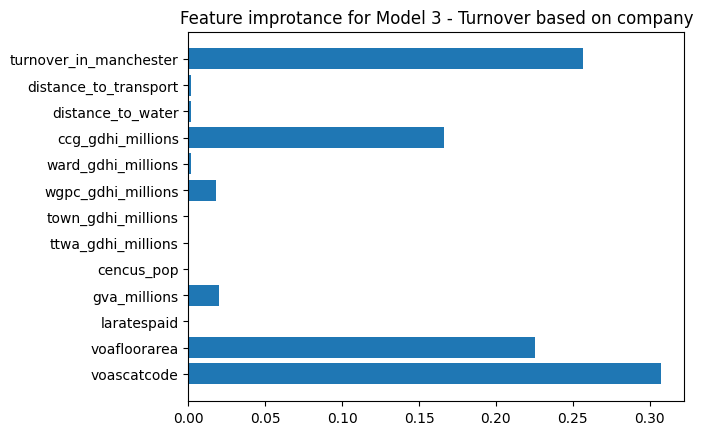

In [70]:
evaluation_df = utils.xgb_model(
    df=estimated_df,
    drop_cols=drop_cols,
    target = "estimated_turnover",
    model_type="Model 3 - Turnover based on company",
    evaluation_df=evaluation_df
)


In [71]:
round(evaluation_df, 2)

,RMSE,STD,MAPE,R2_SCORE,PCT_NEGATIVE_PREDICTIONS
Baseline Model 1,916160.84,1188264.42,3.820000e+00,0.41,0.08
Baseline Model 2 (adding geospatial features),918193.72,1188264.42,4.120000e+00,0.40,0.09
Model 3 - Turnover based on company,43984098.48,60556072.95,1.096910e+20,0.47,0.17


In [69]:
int(1.096910e+20	)

109691000000000000000

1188264.0

## Archive

In [155]:
geolytix_df[geolytix_df["id"] == 1010006336]


,id,retailer,fascia,store_name,add_one,add_two,town,suburb,postcode,longitude,latitude,bng_e,bng_n,pqi,open_date,size_band,county,combined_address
18787,1010006336,Tesco,Tesco Extra,Tesco Altrincham Extra,Manor Road,NaN,Altrincham,Central Altrincham,WA15 9QT,-2.347412,53.385512,376990.000977,387686.038802,Rooftop,NaN,"30,138 ft2 > (2,800 m2)",Greater Manchester,manor road wa15 9qt


In [159]:
loc_df[loc_df["voapropertyaddress"].str.contains(" WA15 9QT")].iloc[:, :]


,ogc_fid,geometry,longitude,latitude,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,turnover_estimate,distance_to_water,nearest_waterway_index,distance_to_transport,nearest_transport_index,normalized_address
42783,2754597,POINT (-261143.058 7054509.499),-2.345888,53.384877,"53 MANOR ROAD, ALTRINCHAM, CHESHIRE, WA15 9QT",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,249,Shops,96.70,6000.0,-9999.0,small_business,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,18000.0,933.701596,4021,209.096973,8722,53 manor road altrincham cheshire wa15 9qt
42784,2755841,POINT (-261143.058 7054509.499),-2.345888,53.384877,"SITE OF 23/39 MANOR ROAD, ALTRINCHAM, CHESHIRE...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,040,Car Parks (Surfaced Open),17.00,5100.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,7650.0,933.701596,4021,209.096973,8722,site of 23/39 manor road altrincham cheshire w...
42785,2762762,POINT (-261143.058 7054509.499),-2.345888,53.384877,"HAND CAR WASH AT TESCO CAR PARK MANOR ROAD, AL...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,045,Car Washes (Stand Alone),1.00,15000.0,-9999.0,"other, small_business",E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,75000.0,933.701596,4021,209.096973,8722,hand car wash at tesco car park manor road alt...
42786,2770010,POINT (-261143.058 7054509.499),-2.345888,53.384877,"AD RIGHT 2019 AT TESCO MANOR ROAD, ALTRINCHAM,...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,003,Advertising Right,1.00,12750.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,19125.0,933.701596,4021,209.096973,8722,ad right 2019 at tesco manor road altrincham c...
42787,2771547,POINT (-261143.058 7054509.499),-2.345888,53.384877,"TESCO SUPERSTORE MANOR ROAD, ALTRINCHAM, CHESH...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,139,Hypermarkets/Superstores (over 2500m^2),8220.77,1500000.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,7500000.0,933.701596,4021,209.096973,8722,tesco superstore manor road altrincham cheshir...
42788,2771548,POINT (-261143.058 7054509.499),-2.345888,53.384877,"TESCO MOBILE AT TESCO SUPERSTORE MANOR ROAD, A...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,508,Shops Within/Part of Specialist Property,37.47,7800.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,39000.0,933.701596,4021,209.096973,8722,tesco mobile at tesco superstore manor road al...
42789,2771549,POINT (-261143.058 7054509.499),-2.345888,53.384877,TESCO FAMILY DINING AT TESCO SUPERSTORE MANOR ...,ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,500,Cafes/Restaurants Within/Part of Specialist Pr...,160.35,33500.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,167500.0,933.701596,4021,209.096973,8722,tesco family dining at tesco superstore manor ...


In [153]:
fuzz.partial_ratio("lloyd street  wa14 2su", 'sainsburys lloyd street altrincham cheshire wa14 2su')

66.66666666666667

In [104]:
test_geo = geolytix_df[geolytix_df.id == 1010000444]
test_openlocal = loc_df[loc_df["voapropertyaddress"].str.contains("LEECH STREET")]

In [134]:
openlocal_coords = np.radians(test_openlocal[["latitude", "longitude"]])
geolytix_coords = np.radians(test_geo[["latitude", "longitude"]])
tree = BallTree(openlocal_coords, metric="haversine")  # Haversine distance (km)

radius = 0.5 / 6371  # Convert 500 meters to radians (Earth radius = 6371 km)
indices_list = tree.query_radius(geolytix_coords, r=radius)

matches = []
for idx, nearby_indices in enumerate(indices_list):
    geo_row = test_geo.iloc[idx]
    candidates = test_openlocal.iloc[nearby_indices]

    # Iterate through all candidates to find the best match
    best_match = None
    best_score = 0
    best_distance = float("inf")
    for i, open_row in candidates.iterrows():
        sim_score = fuzz.partial_ratio(geo_row["combined_address"], open_row["normalized_address"])
        print(sim_score)
        geo_point = (geo_row["latitude"], geo_row["longitude"])
        open_point = (open_row["latitude"], open_row["longitude"])
        distance = geodesic(geo_point, open_point).meters

        # Check if retailer name is present in the OpenLocal address
        retailer_weight = 10 if geo_row["retailer"].lower() in open_row["normalized_address"] else 0
        weighted_score = sim_score + retailer_weight
        test_openlocal.loc[i,"sim_score"] = weighted_score

        # Update the best match based on the weighted score and distance
        if weighted_score > best_score or (weighted_score == best_score and distance < best_distance):
            best_match = open_row
            best_score = weighted_score
            best_distance = distance
print(best_score)

73.17073170731707
73.17073170731707
73.17073170731707
73.17073170731707
73.17073170731707
73.17073170731707
73.17073170731707
83.17073170731707


In [129]:
test_openlocal

,ogc_fid,geometry,longitude,latitude,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,turnover_estimate,distance_to_water,nearest_waterway_index,distance_to_transport,nearest_transport_index,normalized_address,sim_score
48139,2616754,POINT (-229327.502 7072495.901),-2.060084,53.481137,"SELLARS GARAGE FERRODEN WORKS LEECH STREET, ST...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,289,Vehicle Repair Workshops & Garages,129.00,8900.0,0.00,small_business,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,26700.0,161.254806,1385,210.90738,2026,sellars garage ferroden works leech street sta...,73.170732
48140,2619123,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNIT 5 CLOCK TOWER MILL LEECH STREET, STALYBRI...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,268,Stores,291.60,2050.0,0.00,,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,5125.0,161.254806,1385,210.90738,2026,5 clock tower mill leech street stalybridge ch...,73.170732
48141,2623735,POINT (-229327.502 7072495.901),-2.060084,53.481137,"PART 1ST FLOOR THE OLD FOUNDRY LEECH STREET, S...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,096,"Factories, Workshops and Warehouses (Incl Bake...",239.86,7300.0,0.00,,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,18250.0,161.254806,1385,210.90738,2026,1st the old foundry leech street stalybridge ...,73.170732
48142,2623736,POINT (-229327.502 7072495.901),-2.060084,53.481137,"THE OLD FOUNDRY LEECH STREET, STALYBRIDGE, CHE...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,096,"Factories, Workshops and Warehouses (Incl Bake...",1254.85,26750.0,13348.25,,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,66875.0,161.254806,1385,210.90738,2026,the old foundry leech street stalybridge chesh...,73.170732
48143,2624828,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNITS 1-2 CLOCK TOWER WORKS LEECH STREET, STAL...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,096,"Factories, Workshops and Warehouses (Incl Bake...",785.10,17750.0,2125.27,retail,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,44375.0,161.254806,1385,210.90738,2026,s 1-2 clock tower works leech street stalybrid...,73.170732
48144,2624829,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNIT 4 CLOCK TOWER WORKS LEECH STREET, STALYBR...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,096,"Factories, Workshops and Warehouses (Incl Bake...",233.60,8400.0,2995.10,,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,21000.0,161.254806,1385,210.90738,2026,4 clock tower works leech street stalybridge c...,73.170732
48145,2624901,POINT (-229327.502 7072495.901),-2.060084,53.481137,"ALDI LEECH STREET, STALYBRIDGE, CHESHIRE, SK15...",STALYBRIDGE,CHESHIRE,SK15 1SD,0101000000581af8510d7b00c0a1f2afe595bd4a40,E08000008,152,Large Food Stores (750 - 2500m^2),1813.10,280000.0,152880.00,,E01006023,96.150063,1565.0,E30000239,E35000618,E14000967,E05000810,E38000182,54907.789249,526.637265,1787.536226,222.625057,4823.099348,1400000.0,161.254

In [119]:
fuzz.partial_ratio("leech street sk15 1sd", "4 clock tower works leech street stalybridge cheshire sk15 1sd")

75.0

,geolytix_id,geolytix_address,openlocal_id,openlocal_address,similarity,distance_meters
0,1010000444,leech street sk15 1sd,2616754,"SELLARS GARAGE FERRODEN WORKS LEECH STREET, ST...",73.170732,116.950931
1,1010008846,4 fir tree lane sk16 5ew,2619330,"4 FIR TREE LANE, DUKINFIELD, CHESHIRE, SK16 5EW",78.048780,210.393238
2,1010003132,2 lord sheldon way ol6 7te,2624987,AD RIGHT SITE ID 126900 AT J. SAINSBURY'S LORD...,70.370370,316.509494
3,1010005415,397 oldham road ol7 9nu,2622999,"TESCO EXPRESS 397 OLDHAM ROAD, ASHTON-UNDER-LY...",79.166667,282.407384
7,1010021469,wigan road bl3 4lt,233486,"311 WIGAN ROAD, BOLTON, BL3 5QU",73.684211,78.113903
...,...,...,...,...,...,...
630,1010003976,paul house stockport road wa15 7uq,2766184,"SUITE 5A PAUL HOUSE STOCKPORT ROAD, ALTRINCHAM...",79.411765,11.772717
631,1010005870,229 ashley road hale wa15 9sx,2765531,"229 ASHLEY ROAD, ALTRINCHAM, CHESHIRE, WA15 9SX",76.595745,31.026813
633,1010006336,manor road wa15 9qt,2754597,"53 MANOR ROAD, ALTRINCHAM, CHESHIRE, WA15 9QT",70.270270,123.577044
634,1010003319,lloyd street wa14 2su,2762097,"2 LLOYD STREET, ALTRINCHAM, CHESHIRE, WA14 2DE",73.684211,64.438421


,ogc_fid,geometry,longitude,latitude,voapropertyaddress,voapropertytown
48139,2616754,POINT (-229327.502 7072495.901),-2.060084,53.481137,"SELLARS GARAGE FERRODEN WORKS LEECH STREET, ST...",STALYBRIDGE
48140,2619123,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNIT 5 CLOCK TOWER MILL LEECH STREET, STALYBRI...",STALYBRIDGE
48141,2623735,POINT (-229327.502 7072495.901),-2.060084,53.481137,"PART 1ST FLOOR THE OLD FOUNDRY LEECH STREET, S...",STALYBRIDGE
48142,2623736,POINT (-229327.502 7072495.901),-2.060084,53.481137,"THE OLD FOUNDRY LEECH STREET, STALYBRIDGE, CHE...",STALYBRIDGE
48143,2624828,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNITS 1-2 CLOCK TOWER WORKS LEECH STREET, STAL...",STALYBRIDGE
48144,2624829,POINT (-229327.502 7072495.901),-2.060084,53.481137,"UNIT 4 CLOCK TOWER WORKS LEECH STREET, STALYBR...",STALYBRIDGE
48145,2624901,POINT (-229327.502 7072495.901),-2.060084,53.481137,"ALDI LEECH STREET, STALYBRIDGE, CHESHIRE, SK15...",STALYBRIDGE


,id,retailer,fascia,store_name,add_one,add_two,town,suburb,postcode,longitude
399,1010000444,Aldi,Aldi,Aldi Stalybridge,Leech Street,NaN,Stalybridge,Central Stalybridge,SK15 1SD,-2.059078


,ogc_fid,geometry,longitude,latitude,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions,turnover_estimate,distance_to_water,nearest_waterway_index,distance_to_transport,nearest_transport_index,normalized_address
42786,2770010,POINT (-261143.058 7054509.499),-2.345888,53.384877,"AD RIGHT 2019 AT TESCO MANOR ROAD, ALTRINCHAM,...",ALTRINCHAM,CHESHIRE,WA15 9QT,01010000007ba180ed60c402c0c6fd47a643b14a40,E08000009,003,Advertising Right,1.0,12750.0,-9999.0,,E01006194,105.546466,2430.0,E30000239,E35000243,E14000532,E05000831,E38000187,54907.789249,1481.712301,2861.021427,387.037121,5679.234672,19125.0,933.701596,4021,209.096973,8722,ad right 2019 at tesco manor road altrincham c...


In [ ]:
# overture_df = utils.extract_overture_data(min_lon, max_lon, min_lat, max_lat)
# atp_df = utils.extract_all_the_places_data(min_lon, max_lon, min_lat, max_lat)

geolytix_df = pd.read_csv("data/raw/geolytix/geolytix_retailpoints_v33_202408.csv").rename(columns={"long_wgs":"longitude", "lat_wgs":"latitude"})
geolytix_df = geolytix_df[
    (geolytix_df["longitude"] >= min_lon) & (geolytix_df["longitude"] <= max_lon) & (geolytix_df["latitude"] >= min_lat) & (geolytix_df["latitude"] <= max_lat)
]
geolytix_df["longitude"] = round(geolytix_df["longitude"], 6)
geolytix_df["latitude"] = round(geolytix_df["latitude"], 6)

retail_df = geolytix_df.merge(
    gdf.drop(["geometry", "longitude", "latitude", 'voapropertyaddress', 'voapropertytown','voapropertycounty', 'voapropertypostcode', 'voapostcodecentroid'], axis=1), 
    on=["add_one"], how="left")
retail_df = retail_df.replace(r'^\s*$', np.nan, regex=True)
def count_non_null(row):
    return row.notnull().sum()
retail_df['non_null_count'] = retail_df.apply(count_non_null, axis=1)
retail_df = retail_df.sort_values(by=['id', 'non_null_count'], ascending=[True, False])
retail_df = retail_df.drop_duplicates(subset=['id'], keep='first')

df = utils.using_ons_datasets(retail_df)


c:\Users\wail.baalawi\OneDrive - Precisely Software Incorporated\Documents\Personal Projects\geomind\utils.py:81: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ons_lookup = pd.read_csv("data/raw/ons/PCD_OA_LSOA_MSOA_LAD_MAY22_UK_LU.csv", encoding="latin-1")


In [6]:
df.isna().sum()

id                           0
retailer                     0
fascia                       0
store_name                   0
add_one                      0
add_two                    441
town                         0
suburb                      50
postcode                     0
longitude                    0
latitude                     0
bng_e                        0
bng_n                        0
pqi                          0
open_date                  440
size_band                    0
county                       0
voabillingauthoritycode    509
voascatcode                509
voascatname                509
voafloorarea               514
voarateablevalue           523
laratespaid                574
laratesreliefs             619
non_null_count               0
lsoa                         3
gva_millions                 3
cencus_pop                   3
ttwa_code                    3
town_code                    4
pc_code                      3
ward_code                    3
ccg_code

In [6]:
df[df.id == 1010003132]


,id,retailer,fascia,store_name,add_one,add_two,town,suburb,postcode,longitude,latitude,bng_e,bng_n,pqi,open_date,size_band,county,voabillingauthoritycode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid,laratesreliefs,non_null_count,lsoa,gva_millions,cencus_pop,ttwa_code,town_code,pc_code,ward_code,ccg_code,ttwa_gdhi_millions,town_gdhi_millions,wgpc_gdhi_millions,ward_gdhi_millions,ccg_gdhi_millions
123,1010003132,Sainsburys,Sainsburys,Sainsburys Ashton Moss,2 LORD SHELDON WAY,NaN,Ashton Under Lyne,Waterloo,OL6 7TE,-2.105918,53.491396,393070.001028,399414.998877,Rooftop,NaN,"30,138 ft2 > (2,800 m2)",Greater Manchester,E08000008,139,Hypermarkets/Superstores (over 2500m^2),7097.41,1240000.0,677040.0,NaN,21,E01005948,418.249581,2245.0,E30000239,E35000787,E14000537,E05000816,E38000182,54907.789249,768.690987,1657.648548,193.535906,4823.099348


In [ ]:
# Resuming with Openstreetmap data... (see above for task list)

,osm_id,code,fclass,name,layer,bridge,tunnel,geometry
0,928999,6101,rail,Liverpool to Manchester Line,0,F,F,"LINESTRING (-2.28446 53.48026, -2.29499 53.481..."
1,929904,6101,rail,Liverpool to Manchester Line,0,F,F,"LINESTRING (-2.2918 53.46196, -2.29249 53.4618..."
2,929905,6102,light_rail,Metrolink,0,F,F,"LINESTRING (-2.2794 53.46058, -2.27997 53.46022)"
3,3663332,6102,light_rail,None,0,F,F,"LINESTRING (-2.23821 53.4818, -2.23817 53.4817..."
4,3996086,6101,rail,West Coast Main Line,0,F,F,"LINESTRING (-2.60031 53.46043, -2.60053 53.460..."
...,...,...,...,...,...,...,...,...
3892,1319220899,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06548 53.40654, -2.0657 53.4066..."
3893,1319220900,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06584 53.40683, -2.06571 53.406..."
3894,1319220901,6101,rail,Hope Valley Line Rosehill Branch,0,F,F,"LINESTRING (-2.06719 53.40319, -2.0668 53.4034..."
3895,1319223135,6101,rail,Hope Valley Line,0,F,F,"LINESTRING (-2.11232 53.42372, -2.1115 53.42343)"


In [5]:
overture_df["categories_primary"] = overture_df.categories.fillna("Unknown").apply(lambda x: x["primary"] if isinstance(x, dict) else "Unknown")

In [15]:
tesco_overture = overture_df[overture_df.names_primary.str.startswith("TESCO")]
print(tesco_overture.shape)
tesco_atp = atp_df[atp_df.spider_id.str.startswith("tesco")]
print(tesco_atp.shape)
tesco_test = tesco_atp.merge(tesco_overture[["names_primary", "longitude", "latitude", "categories", "categories_primary"]], on=["longitude", "latitude"],  how="left")

(220, 11)
(162, 12)


In [29]:
tesco_overture[
    (tesco_overture["longitude"] == -2.425578)
    & (tesco_overture["latitude"] == 53.418544)
     
]

,id,names_primary,address,city,state,postcode,geometry,longitude,latitude,categories,categories_primary
1169,08f1951a059142a103e72af6e55ccedc,TESCO EXPRESS,CENTRAL RD,PARTINGTON,None,M31 4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",-2.425578,53.418544,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket


In [33]:
tesco_test[tesco_test["postcode"].str.startswith("M31")]
tesco_test

,longitude,latitude,spider_id,shop,full_address,address,city,postcode,business_name,branch,website,brand,names_primary,categories,categories_primary
0,-2.353317,53.517281,tesco_gb,convenience,NaN,Former Brook Tavern 656 Manchester Rd,NaN,M27 9RA,Tesco Express,Manchester Swinton,https://www.tesco.com/store-locator/worsley/fo...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket
1,-2.205895,53.349625,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Pharmacy,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN
2,-2.202831,53.349394,tesco_gb,NaN,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN
3,-2.205893,53.349615,tesco_gb,supermarket,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco Extra,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco Extra,NaN,NaN,NaN
4,-2.205924,53.349493,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Café,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/k...,Tesco,TESCO CAFE,"{'primary': 'shopping_center', 'alternate': ['...",shopping_center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-2.347290,53.385508,tesco_gb,NaN,NaN,Manor Road,NaN,WA15 9QT,Tesco Pharmacy,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco,TESCO PHARMACY,"{'primary': 'pharmacy', 'alternate': ['drugsto...",pharmacy
158,-2.347339,53.385499,tesco_gb,NaN,NaN,Manor Road,NaN,WA15 9QT,Tesco Café,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco,TESCO CAFE,"{'primary': 'cafe', 'alternate': ['restaurant']}",cafe
159,-2.347299,53.385554,tesco_gb,supermarket,NaN,Manor Road,NaN,WA15 9QT,Tesco Extra,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Extra,NaN,NaN,NaN
160,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket


In [31]:
gdf[gdf["voapropertypostcode"].str.startswith("M31 4EL")]

,_uid_,ogc_fid,voabillingauthoritycode,voabillingauthorityname,voabillingauthorityrefcode,voauarn,labillingreferencecode,laratepayername,laaccountstartdate,larecorddate,laoccupationstate,laoccupationstatedate,laratespaid,laratesreliefs,laratesreliefsamount,laratesreliefsdate,voapropertyaddress,voapropertytown,voapropertycounty,voapropertypostcode,voapostcodecentroid,lacorrespondenceaddress,voascatcode,voascatname,voasubcategory,voacategory,voastartdate,voafloorarea,voarateablevalue,laupdatecycle,voaepoch,geometry,longitude,latitude
17249,17250,2755665,E08000009,Trafford,,196423116,22630675,,,,,,,,,,"SHOP A SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,54.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17250,17251,2754343,E08000009,Trafford,,76719116,22630350,,,,,,,,,,"6 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,50.9,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17251,17252,2754344,E08000009,Trafford,,76720116,22630375,,,,,,,,,,"7 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,52.5,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17252,17253,2754345,E08000009,Trafford,,76721116,22630400,,,,,,,,,,"8 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,55.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17253,17254,2754329,E08000009,Trafford,,76698116,22630725,,,,,,,,,,"SHOP C SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,024,Betting Offices,RETAIL_FINANCIAL_AND_PROFESSIONAL_SERVICES,RETAIL,2011-03-22,48.8,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17254,17255,2754330,E08000009,Trafford,,76704116,22630550,,,,,,,,,,"15 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,021,Banks/Insurance/Building Society Offices & Oth...,RETAIL_FINANCIAL_AND_PROFESSIONAL_SERVICES,RETAIL,2014-06-17,144.33,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17255,17256,2754331,E08000009,Trafford,,76705116,22630125,,,,,,,,,,"1 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,55.8,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17256,17257,2754332,E08000009,Trafford,,76706116,22630450,,,,,,,,,,"10/10A SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,254.03,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17257,17258,2754333,E08000009,Trafford,,76707116,22630475,,,,,,,,,,"11 AND 12 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,205.1,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873
17258,17259,2754334,E08000009,Trafford,,76708116,22630500,,,,,,,,,,"13 SHOPPING CENTRE, MANCHESTER, M31 4EL",MANCHESTER,,M31 4EL,0101000000425e0f26c56703c0b51666a19db54a40,,249,Shops,RETAIL_HIGH_STREET,RETAIL,2011-03-22,87.5,,,2010-0046-0000,POINT (-2.42567 53.41887),-2.425669,53.418873


In [21]:
tesco_test.merge(
    gdf[["longitude", "latitude", "voapropertypostcode", "voascatcode", "voascatname", "voafloorarea", "voarateablevalue", "laratespaid"]],
    on=["longitude", "latitude"],  how="left"
)

,longitude,latitude,spider_id,shop,full_address,address,city,postcode,business_name,branch,website,brand,names_primary,categories,categories_primary,voapropertypostcode,voascatcode,voascatname,voafloorarea,voarateablevalue,laratespaid
0,-2.353317,53.517281,tesco_gb,convenience,NaN,Former Brook Tavern 656 Manchester Rd,NaN,M27 9RA,Tesco Express,Manchester Swinton,https://www.tesco.com/store-locator/worsley/fo...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.205895,53.349625,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Pharmacy,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.202831,53.349394,tesco_gb,NaN,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.205893,53.349615,tesco_gb,supermarket,NaN,"Tesco Stores Ltd, Kiln Croft Lane Handforth",NaN,SK9 3PA,Tesco Extra,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/t...,Tesco Extra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.205924,53.349493,tesco_gb,NaN,NaN,Kiln Croft Lane Handforth,NaN,SK9 3PA,Tesco Café,Wilmslow Handforth,https://www.tesco.com/store-locator/wilmslow/k...,Tesco,TESCO CAFE,"{'primary': 'shopping_center', 'alternate': ['...",shopping_center,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,409,Cafes,67.55,4900.0,
164,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,018,ATMs,1.0,,
165,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,249,Shops,207.96,,
166,-2.311650,53.392414,tesco_gb,convenience,NaN,57 - 59 Briarfield Road Timperley,NaN,WA15 7DD,Tesco Express,Altrincham,https://www.tesco.com/store-locator/altrincham...,Tesco Express,TESCO EXPRESS,"{'primary': 'supermarket', 'alternate': ['reta...",supermarket,WA15 7DD,249,Shops,338.77,16750.0,


In [11]:
tesco_test[tesco_test.postcode_x.str.startswith("M31")]

,longitude,latitude,spider_id,shop,full_address,address_x,city_x,postcode_x,business_name,branch,website,brand,id,names_primary,address_y,city_y,state,postcode_y,geometry,categories,categories_primary
39,-2.425578,53.418544,tesco_gb,convenience,NaN,Central Rd,NaN,M31 4EL,Tesco Express,Central Rd,https://www.tesco.com/store-locator/partington...,Tesco Express,08f1951a059142a103e72af6e55ccedc,TESCO EXPRESS,CENTRAL RD,PARTINGTON,None,M31 4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","{'primary': 'supermarket', 'alternate': ['reta...",supermarket
